# Can a neural net trained on handwritten digits determine printed digits?

In [47]:
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from skimage import io, color
from sklearn import metrics

import seaborn as sns
import numpy as np
import keras
import random
import glob
import os

%matplotlib inline

In [2]:
# https://github.com/keras-team/keras/issues/4981
inv_binary = np.argmax

# Load Data

In [3]:
num_classes = 10

In [4]:
# load mnist data
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

# normalize to [0, 1]
mnist_x_train = mnist_x_train.astype("float64") / 255
mnist_x_test = mnist_x_test.astype("float64") / 255

# retain test labels
mnist_label_test = mnist_y_test.copy()

# binarize labels
mnist_y_train = keras.utils.to_categorical(mnist_y_train, num_classes)
mnist_y_test = keras.utils.to_categorical(mnist_y_test, num_classes)

In [6]:
# printed digits..
printed_x = []
printed_y = []
printed_label = []

for path in glob.iglob("google-font-images/ofl/*/*/*.png"):
    filename = os.path.split(path)[1]
    label = int(filename.split(".")[0])
    image = io.imread(path, as_grey=True)
    printed_x.append(image)
    printed_y.append(label)
    printed_label.append(label)
    
printed_x = np.array(printed_x) # store as numpy array
printed_y = keras.utils.to_categorical(np.array(printed_y), num_classes)  # binarize category

In [7]:
def reshape(arr):
    sh = list(arr.shape)
    if sh[-1] == 1:
        return arr
    sh.append(1)
    return arr.reshape(*tuple(sh))

mnist_x_train = reshape(mnist_x_train)
mnist_x_test = reshape(mnist_x_test)
printed_x = reshape(printed_x)

In [15]:
print(
    "MNIST Train X   ", mnist_x_train.shape, mnist_x_train.dtype,
    "\nPrinted X     ", printed_x.shape, printed_x.dtype,
    "\nMNIST Train Y ", mnist_y_train.shape, mnist_y_train.dtype,
    "\nPrinted Y     ", printed_y.shape, printed_y.dtype
)

MNIST Train X    (60000, 28, 28, 1) float64 
Printed X      (24280, 28, 28, 1) float64 
MNIST Train Y  (60000, 10) float64 
Printed Y      (24280, 10) float64


# MNIST -> Printed

In [16]:
input_shape = (28, 28, 1)
batch_size = 128
epochs = 20

In [17]:
mnist_model = Sequential()
mnist_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
mnist_model.add(Conv2D(64, (3, 3), activation='relu'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
mnist_model.add(Dropout(0.25))
mnist_model.add(Flatten())
mnist_model.add(Dense(128, activation='relu'))
mnist_model.add(Dropout(0.5))
mnist_model.add(Dense(num_classes, activation='softmax'))

mnist_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy'])

mnist_model.fit(
    mnist_x_train, mnist_y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(mnist_x_test, mnist_y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 14s - loss: 0.3322 - acc: 0.8977 - val_loss: 0.0760 - val_acc: 0.9760
Epoch 2/20
60000/60000 [==============================] - 11s - loss: 0.1146 - acc: 0.9674 - val_loss: 0.0523 - val_acc: 0.9833
Epoch 3/20
60000/60000 [==============================] - 11s - loss: 0.0884 - acc: 0.9735 - val_loss: 0.0446 - val_acc: 0.9851
Epoch 4/20
60000/60000 [==============================] - 11s - loss: 0.0732 - acc: 0.9778 - val_loss: 0.0384 - val_acc: 0.9869
Epoch 5/20
60000/60000 [==============================] - 11s - loss: 0.0646 - acc: 0.9803 - val_loss: 0.0384 - val_acc: 0.9874
Epoch 6/20
60000/60000 [==============================] - 11s - loss: 0.0551 - acc: 0.9828 - val_loss: 0.0349 - val_acc: 0.9882
Epoch 7/20
60000/60000 [==============================] - 11s - loss: 0.0503 - acc: 0.9848 - val_loss: 0.0340 - val_acc: 0.9891
Epoch 8/20
60000/60000 [==============================

# Measurements

In [18]:
# performance on mnist test data
score = mnist_model.evaluate(mnist_x_test, mnist_y_test, verbose=0)
print("Loss", score[0])
print("Accuracy", score[1])

Loss 0.0311995676307
Accuracy 0.9912


In [19]:
# performance on printed data
score = mnist_model.evaluate(printed_x, printed_y, verbose=0)
print("Loss", score[0])
print("Accuracy", score[1])

Loss 2.58059331593
Accuracy 0.584925864919


In [20]:
# performance on random samples of printed data
size = printed_x.shape[0]
for _ in range(10):
    indexes = random.sample(range(size), k=int(.10 * size))
    printed_x_test = printed_x[indexes, :, :, :]
    printed_y_test = printed_y[indexes, :]
    score = mnist_model.evaluate(printed_x_test, printed_y_test, verbose=0)
    print(score)

[2.5220927885768836, 0.60049423374100608]
[2.5884461320408878, 0.58772652418256]
[2.6277750728550617, 0.58031301512160449]
[2.6772414903467925, 0.56466227367250299]
[2.6540219500980031, 0.57537067604222059]
[2.5265858318699643, 0.57866556915459166]
[2.5165913057877165, 0.5757825373621317]
[2.6072094483666208, 0.5823723228995058]
[2.6803853256502106, 0.57372322919144858]
[2.5281341574730156, 0.57948929238358671]


In [21]:
# performance per class label
for c in range(num_classes):
    indexes_c = [idx for idx, i in enumerate(printed_label) if i == c]
    printed_x_test = printed_x[indexes_c, :, :, :]
    printed_y_test = printed_y[indexes_c, :]
    print("Class ", c, mnist_model.evaluate(printed_x_test, printed_y_test, verbose=0))

Class  0 [2.9682820748654386, 0.59967051070840194]
Class  1 [0.70328864165546479, 0.81219110418190865]
Class  2 [4.6394065702963108, 0.27429983535354968]
Class  3 [0.62834137781251598, 0.80848434984782191]
Class  4 [7.6246151146425252, 0.1515650741350906]
Class  5 [0.71417379106780055, 0.81136738134569553]
Class  6 [2.4481866277226505, 0.38385502474852018]
Class  7 [0.57448655133683368, 0.84925864948668628]
Class  8 [1.8289191594625067, 0.69439868223922452]
Class  9 [3.6762333438659618, 0.46416803944051954]


In [22]:
# performance per class label on a random sample
for c in range(num_classes):
    indexes_c = [idx for idx, i in enumerate(printed_label) if i == c]
    sample_indexes = random.sample(indexes_c, k=int(0.50 * len(indexes_c)))
    printed_x_test = printed_x[sample_indexes, :, :, :]
    printed_y_test = printed_y[sample_indexes, :]
    print("Class ", c, mnist_model.evaluate(printed_x_test, printed_y_test, verbose=0))

Class  0 [2.8526751839937843, 0.61202635953610973]
Class  1 [0.69103922566039955, 0.80642504197172515]
Class  2 [4.5045940864223626, 0.29077430022803719]
Class  3 [0.58710206595834047, 0.81713344502881091]
Class  4 [7.6620190650273781, 0.14744645816195737]
Class  5 [0.68123259467780095, 0.82207578420639038]
Class  6 [2.4708060534821312, 0.38632619533153895]
Class  7 [0.54414154670187431, 0.86243822242714818]
Class  8 [1.9186154448809301, 0.67957166509926814]
Class  9 [3.6608835947768887, 0.45881383938490855]


# Confusion Matrices

In [52]:
def confusion_matrix(model, x_true, y_true):
    prob = model.predict(x_true)
    y_pred = np.argmax(prob, axis=1)  # class label of predicted
    y_true = np.argmax(y_true, axis=1)  # class label of actual
    matrix = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(matrix)

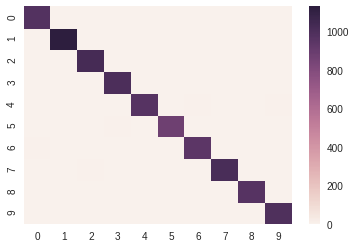

In [54]:
confusion_matrix(mnist_model, mnist_x_test, mnist_y_test)

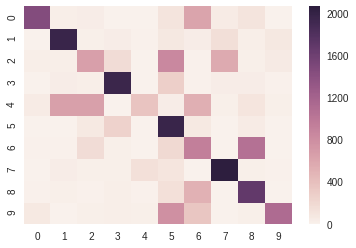

In [53]:
confusion_matrix(mnist_model, printed_x, printed_y)

# Printed -> MNIST

In [55]:
input_shape = (28, 28, 1)
batch_size = 128
epochs = 20

In [56]:
printed_model = Sequential()
printed_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
printed_model.add(Conv2D(64, (3, 3), activation='relu'))
printed_model.add(MaxPooling2D(pool_size=(2, 2)))
printed_model.add(Dropout(0.25))
printed_model.add(Flatten())
printed_model.add(Dense(128, activation='relu'))
printed_model.add(Dropout(0.5))
printed_model.add(Dense(num_classes, activation='softmax'))

printed_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy'])

printed_model.fit(
    printed_x, printed_y,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.3)

Train on 16996 samples, validate on 7284 samples
Epoch 1/20
16996/16996 [==============================] - 3s - loss: 0.9144 - acc: 0.7186 - val_loss: 0.3604 - val_acc: 0.9051
Epoch 2/20
16996/16996 [==============================] - 3s - loss: 0.3439 - acc: 0.9061 - val_loss: 0.2178 - val_acc: 0.9428
Epoch 3/20
16996/16996 [==============================] - 3s - loss: 0.2445 - acc: 0.9324 - val_loss: 0.1843 - val_acc: 0.9509
Epoch 4/20
16996/16996 [==============================] - 3s - loss: 0.2005 - acc: 0.9458 - val_loss: 0.1662 - val_acc: 0.9551
Epoch 5/20
16996/16996 [==============================] - 3s - loss: 0.1705 - acc: 0.9515 - val_loss: 0.1496 - val_acc: 0.9598
Epoch 6/20
16996/16996 [==============================] - 3s - loss: 0.1503 - acc: 0.9566 - val_loss: 0.1460 - val_acc: 0.9602
Epoch 7/20
16996/16996 [==============================] - 3s - loss: 0.1361 - acc: 0.9608 - val_loss: 0.1371 - val_acc: 0.9633
Epoch 8/20
16996/16996 [==============================] - 3s -

In [59]:
# MNIST test data (loss, acc)
printed_model.evaluate(mnist_x_test, mnist_y_test, verbose=0)

[1.5691589190006257, 0.70920000000000005]

In [60]:
# MNIST per class label
for c in range(num_classes):
    indexes_c = [idx for idx, i in enumerate(mnist_label_test) if i == c]
    x_test = mnist_x_test[indexes_c, :, :, :]
    y_test = mnist_y_test[indexes_c, :]
    print("Class ", c, printed_model.evaluate(x_test, y_test, verbose=0))

Class  0 [0.41329137983979009, 0.90714285738614142]
Class  1 [0.17855054405292226, 0.94361233564200375]
Class  2 [3.5810636198797892, 0.36434108527131781]
Class  3 [0.61693644228548106, 0.83168316902500572]
Class  4 [4.3206466836987589, 0.40733197592426462]
Class  5 [0.533523861135068, 0.88004484318297005]
Class  6 [1.3188778572639992, 0.69311064954590451]
Class  7 [0.32653828421861725, 0.92023346303501941]
Class  8 [2.9722144265928798, 0.4661190966316317]
Class  9 [1.5384180451290104, 0.66105054562580956]


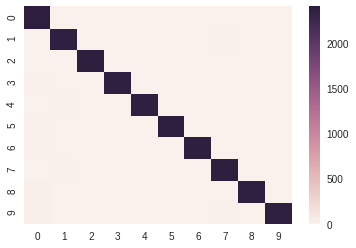

In [62]:
confusion_matrix(printed_model, printed_x, printed_y)

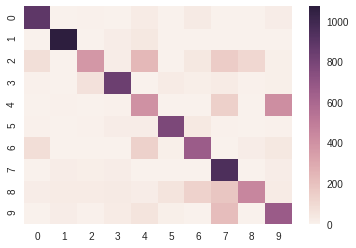

In [61]:
confusion_matrix(printed_model, mnist_x_test, mnist_y_test)